In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

In [3]:
import networkx as nx
import json
from utils.weights_graph import set_graph_weights
from utils.basic import mc_upper_bound, func_max
from utils.classic_computation import *
import pickle
from tqdm import tqdm
import dwave_networkx as dnx

# Load G

In [7]:
n_nodes = '613'
n_edges = '167263'
filename = f'../input/actual/graph{n_nodes}_{n_edges}.json'
with open(filename, 'r') as file:
    graph_data = json.load(file)
Original = nx.Graph()
Original.add_edges_from([tuple(edge) for edge in graph_data['edges']])
a=0
b=0.027290137282490516
c=d=0.03640364796375065
e=f=0.08197120137005134
const = [a,b,c,d,e,f]
set_graph_weights(Original, graph_data['vertices'], const)
with open("../input/mapping/mapping.pkl", "rb") as f:
    mapping = pickle.load(f)
G = nx.relabel_nodes(Original, mapping, copy=True)
w1 = nx.get_node_attributes(G, "w1")
w2 = nx.get_node_attributes(G, "w2")
w3 = nx.get_node_attributes(G, "w3")
w4 = nx.get_node_attributes(G, "w4")
w1_sort ={k: v for k, v in sorted(w1.items(), key=lambda item: item[1], reverse= True)}
w2_sort ={k: v for k, v in sorted(w2.items(), key=lambda item: item[1], reverse= True)}
w3_sort ={k: v for k, v in sorted(w3.items(), key=lambda item: item[1], reverse= True)}
w4_sort ={k: v for k, v in sorted(w4.items(), key=lambda item: item[1], reverse= True)}
v1 = max(w1_sort.values())
v2 = max(w2_sort.values())
v3 = max(w3_sort.values())
v4 = max(w4_sort.values())

# Finding starting points

In [8]:
# Creating G1 removing nodes with w1 and w2 not max and keeping nodes with w3>w3_max/168.52
G1= G.copy()
for k in w1.keys():
    if w1[k]<v1 or w2[k]<v2 or w3[k]<v3/168.52:
        G1.remove_node(k)
print(len(G1.nodes()))
print(mc_upper_bound(G1))

122
9


In [9]:
# Use find_cliques func for find alla cliques
clis =list(nx.find_cliques(G1))
cliques_val = []
for i in tqdm(clis):
    sumw4=0
    for node in i:
        sumw4+=w4[node]
    cliques_val.append(sumw4)

100%|██████████| 10008467/10008467 [00:09<00:00, 1106353.76it/s]


In [10]:
# Filtering results to fine the ones with max function values
max_val = max(cliques_val)
start_cliques  = [cli for cli,val in zip(clis, cliques_val) if val >= max_val]
start_cliques = [sorted(cli) for cli in start_cliques]
start_cliques = list(map(list, {tuple(sublist) for sublist in start_cliques}))
print(max([len(cli) for cli in start_cliques]))
print(max_val)

9
0.24831508986982237


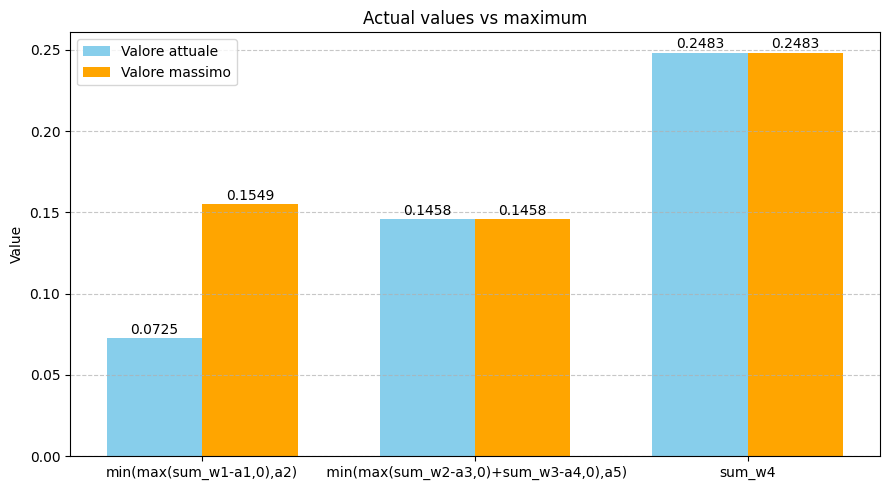

In [11]:
# Show value of function parts
p1,p2,p3 = partial_func(w1,w2,w3,w4,start_cliques[0])
draw_max(p1,p2,p3)

# Finding solutions with 21 nodes

### With 1 starting point

In [12]:
G2 = find_bigger_graph(G, start_cliques[0],[],[])
g_rem = remove_nodes_ub(G2, start_cliques[0], w1)

100%|██████████| 221/221 [00:01<00:00, 131.94it/s]


In [13]:
# Show results from G rem using find cliques
# In almost all cases, g_rem is already a clique, but to be on the safe side, it is better to use find_cliques
clis = list(nx.find_cliques(g_rem))
cliques = list(map(list, {tuple(sublist) for sublist in clis}))
cliques_values = [func_max(G, i) for i in cliques]
combined = list(zip(cliques_values, cliques))
combined = sorted(combined, reverse=True)
maxval = max([x[0] for x in combined])
max_cliques = [x[1] for x in combined if x[0] == maxval]
len_max_cliques =  sum(1 for x in combined if x[0] == maxval)
for val,cli in combined:
     print(f"Clique {cli} with value {val} --> len = {len(cli)}")

Clique [321, 519, 520, 481, 606, 428, 524, 525, 473, 109, 399, 464, 498, 562, 371, 407, 505, 508, 93, 413, 479] with value 0.5489601528288273 --> len = 21


### All starting points

In [14]:
f_max = []
clis = []
# can change start_cliques[0:20] up to start_cliques[0:399]
for i in tqdm(start_cliques[0:20]):
    g1 = find_bigger_graph(G, i, [],[])
    if mc_upper_bound(g1)==21:
        g1_rem = remove_nodes_ub(g1, i, w1)
        if dnx.is_clique(G, g1_rem.nodes()):
            f_max.append(func_max(G,g1_rem.nodes()))
            clis.append(g1_rem.nodes())

100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


In [15]:
combined = list(zip(f_max, clis))
for val,cli in combined:
     print(f"Clique {cli} with value {val} --> len = {len(cli)}")

Clique [93, 109, 321, 371, 399, 407, 413, 428, 464, 473, 479, 481, 498, 505, 508, 519, 520, 524, 525, 562, 606] with value 0.548960152828827 --> len = 21
Clique [11, 90, 92, 109, 321, 371, 381, 399, 407, 413, 428, 473, 498, 505, 508, 519, 520, 524, 525, 562, 606] with value 0.5489601528288272 --> len = 21
Clique [7, 11, 92, 107, 109, 321, 371, 399, 407, 413, 428, 473, 498, 505, 508, 519, 520, 524, 525, 562, 606] with value 0.5489601528288272 --> len = 21
Clique [93, 109, 316, 321, 371, 381, 399, 407, 413, 428, 464, 473, 498, 505, 508, 519, 520, 524, 525, 562, 606] with value 0.5489601528288272 --> len = 21
Clique [90, 106, 109, 318, 321, 371, 399, 407, 413, 428, 465, 473, 498, 505, 508, 519, 520, 524, 525, 562, 606] with value 0.5489601528288272 --> len = 21
Clique [11, 109, 316, 318, 321, 342, 371, 399, 407, 413, 428, 473, 498, 505, 508, 519, 520, 524, 525, 562, 606] with value 0.5489601528288272 --> len = 21
Clique [90, 92, 109, 321, 371, 399, 407, 413, 428, 465, 473, 479, 498, 505, 

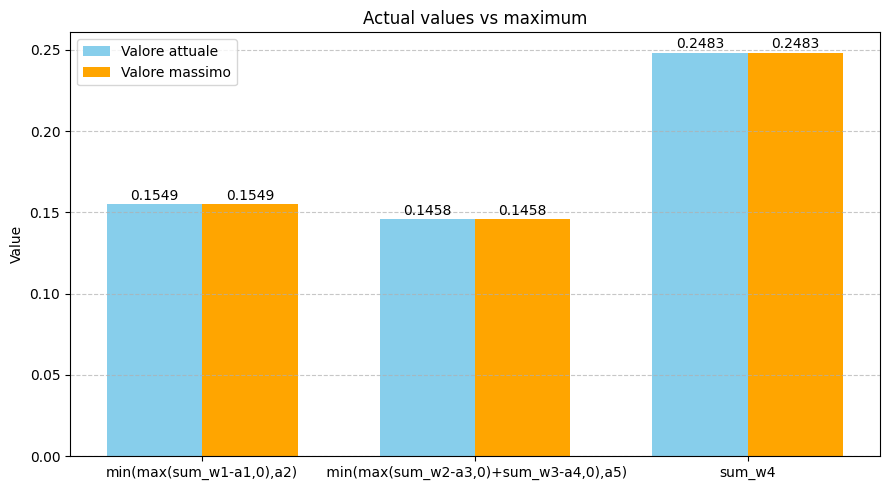

In [16]:
# Show value of function parts
p1,p2,p3 = partial_func(w1,w2,w3,w4,clis[0])
draw_max(p1,p2,p3)